# Notebook : Full E2E using llama index


In [26]:
from moviepy.editor import VideoFileClip
from pathlib import Path
import speech_recognition as sr
from pytubefix import YouTube
from pprint import pprint
from dotenv import load_dotenv
import rich
import json
import os
from PIL import Image
import matplotlib.pyplot as plt
from youtube_transcript_api import YouTubeTranscriptApi
import re
import rich

## helper functions

In [2]:
def plot_images(image_paths):
    images_shown = 0
    plt.figure(figsize=(16, 9))
    for img_path in image_paths:
        if os.path.isfile(img_path):
            image = Image.open(img_path)

            plt.subplot(2, 3, images_shown + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])

            images_shown += 1
            if images_shown >= 7:
                break

In [3]:

# %pip install llama-index-multi-modal-llms-gemini
# %pip install llama-index-vector-stores-qdrant
# %pip install llama-index-embeddings-gemini
# %pip install llama-index-llms-gemini

In [4]:
# !pip install llama-index 'google-generativeai>=0.3.0' matplotlib qdrant_client

In [5]:
load_dotenv(dotenv_path="../env")



True

In [6]:
def get_video_metadata(yt:YouTube):
    #yt = YouTube(video_id)

    return {
        "video_id": yt.video_id,
        "title": yt.title,
        "author": yt.author,
        "keywords": yt.keywords,

        "publish_date": yt.publish_date.isoformat(),

        "length": yt.length,
        "likes": yt.likes,
        "views": yt.views,
        "channel_id": yt.channel_id,
        "thumbnail_url": yt.thumbnail_url,
        "description": yt.description,

    }


def get_youtube_id(link:str):
    """Extracts the video ID from a YouTube video link."""
    if "youtube.com" in link:
        pattern = r'youtube\.com/watch\?v=([a-zA-Z0-9_-]+)'
        video_id = re.search(pattern, link).group(1)
        return video_id
    elif "youtu.be" in link:
        pattern = r"youtu\.be/([a-zA-Z0-9_-]+)"
        video_id = re.search(pattern, link).group(1)
        return video_id
    else:
        return None

def get_transcript(video_id:str):
    try:
        transcript_dict = YouTubeTranscriptApi.get_transcript(video_id)
        final_transcript = " ".join(i["text"] for i in transcript_dict)
        return final_transcript , transcript_dict
    except Exception as e:
        print(e)


def get_transcript_time(link:str):
    """Gets the transcript of a YouTube video with timestamps."""
    video_id =get_youtube_id(link)

    try:
        transcript_dict = YouTubeTranscriptApi.get_transcript(video_id)
        final_transcript = ""
        for i in transcript_dict:
            timevar = round(float(i["start"]))
            hours = int(timevar // 3600)
            timevar %= 3600
            minutes = int(timevar // 60)
            timevar %= 60
            timevex = f"{hours:02d}:{minutes:02d}:{timevar:02d}"
            final_transcript += f'{i["text"]} "time:{timevex}" '
        return final_transcript
    except Exception as e:
        print(e)
        return video_id



def download_video(video_id:str, output_path):
    """
    Download a video from a given url and save it to the output path.

    Parameters:
    url (str): The url of the video to download.
    output_path (str): The path to save the video to.

    Returns:
    dict: A dictionary containing the metadata of the video.
    """

    url =  f"https://www.youtube.com/watch?v={video_id}"
    print (url)
    yt = YouTube(url, use_po_token=False)
    metadata = get_video_metadata(yt)

    transcript,transcript_dict = get_transcript(video_id)

    with open(os.path.join(output_path,"transcript.txt"),"w") as f:
        f.write(transcript)



    with open(os.path.join(output_path,"metadata.json"),"w") as f:
        json.dump(metadata,f, indent=4)

    yt.streams.get_highest_resolution().download(
        output_path=output_path, filename="video.mp4"
    )
    return metadata


def video_to_images(video_path, output_folder,fps=0.2):
    """
    Convert a video to a sequence of images and save them to the output folder.

    Parameters:
    video_path (str): The path to the video file.
    output_folder (str): The path to the folder to save the images to.

    """
    clip = VideoFileClip(video_path)

    os.makedirs(os.path.join(output_folder,"images"), exist_ok=True)
    clip.write_images_sequence(
        os.path.join(output_folder,"images", "frame%04d.png"), fps=fps
    )


In [7]:
# sample youtube videos
video_id_1 = "cqvWjpw2h5Y"
video_id_2 = "ODluYyMZzs0"

video_ids = [video_id_1 , video_id_2]

In [8]:
data_folder ="../data"
os.makedirs(data_folder, exist_ok=True)

# videos, frames, and audio files will be saved here
output_folder = "../data/"
Path(output_folder).mkdir(parents=True, exist_ok=True)


In [9]:
# retrieve videos and process them.
for video_id in video_ids:
    print (video_id)
    output_folder = os.path.join(data_folder, video_id)
    os.makedirs(output_folder, exist_ok=True)
    metadata = download_video(video_id,output_folder)
    video_file_path = os.path.join(output_folder, "video.mp4")
    video_to_images(video_file_path, output_folder)

cqvWjpw2h5Y
https://www.youtube.com/watch?v=cqvWjpw2h5Y
Moviepy - Writing frames ../data/cqvWjpw2h5Y/images/frame%04d.png.


Moviepy - Done writing frames ../data/cqvWjpw2h5Y/images/frame%04d.png.
ODluYyMZzs0
https://www.youtube.com/watch?v=ODluYyMZzs0
Moviepy - Writing frames ../data/ODluYyMZzs0/images/frame%04d.png.


Moviepy - Done writing frames ../data/ODluYyMZzs0/images/frame%04d.png.


# specify the model specification


In [10]:
from llama_index.core.indices import MultiModalVectorStoreIndex
from llama_index.core import SimpleDirectoryReader, StorageContext
from llama_index.vector_stores.lancedb import LanceDBVectorStore
from llama_index.core import Settings
from llama_index.core import SimpleDirectoryReader
from llama_index.embeddings.openai import OpenAIEmbedding
from llama_index.llms.openai import OpenAI
from llama_index.multi_modal_llms.openai import OpenAIMultiModal

## llm model's api keys

In [11]:
# import os

# OPENAI_API_KEY = ""
# os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

## embedding model

In [12]:
# embeddings model to use.
embed_model = OpenAIEmbedding(
    model="text-embedding-3-small",
    dimensions=512,
)
# update settings for llama_index
Settings.embed_model = embed_model

## llm model

In [13]:
#specify the OpenAI model to use.
llm_model  = OpenAI(model="gpt-4o-mini")

# update settings for llama_index
Settings.llm = llm_model

# generate embeddings

In [14]:
def file_metadata(file_path:str):
    parent_dir = os.path.dirname(file_path)

    if ".png" in file_path:
        path_metadata_folder = os.path.join(parent_dir,"..")
    elif ".txt" in file_path:
         path_metadata_folder = parent_dir
    path_metadata = os.path.join(path_metadata_folder, "metadata.json")
    metadata = json.load(open(path_metadata))
    del metadata["description"]
    del metadata["keywords"]

    return metadata

In [15]:
from llama_index.core.node_parser import SentenceSplitter

# set to false if embeddings are available
_create_new_embeddings = True

if _create_new_embeddings:
    # text embeddings store
    text_store = LanceDBVectorStore(uri="lancedb", table_name="text_collection")
    # image embeddings store
    image_store = LanceDBVectorStore(uri="lancedb", table_name="image_collection")


    storage_context = StorageContext.from_defaults(
        vector_store=text_store, image_store=image_store
    )
    # Create the MultiModal index
    documents = SimpleDirectoryReader(
        data_folder,
        required_exts=[".txt",".png"],
        recursive=True,
        file_metadata = file_metadata
    ).load_data(show_progress= True)

    # split the document into 512 token size
    splitter = SentenceSplitter(chunk_size=512)
    index = MultiModalVectorStoreIndex.from_documents(
        documents,
        storage_context=storage_context,
        transformations=[splitter]
    )
    # persist the data, default it will be saved at ./storage
    # persisted embedding data can loaded easily loaded
    index.storage_context.persist()
else:
    text_store = LanceDBVectorStore(uri="lancedb", table_name="text_collection")
    image_store = LanceDBVectorStore(uri="lancedb", table_name="image_collection")

    storage_context = StorageContext.from_defaults(
        vector_store=text_store, image_store=image_store, persist_dir="./storage"
    )
    # use existing embeddings
    from llama_index.core import (
        load_index_from_storage,
        load_indices_from_storage,
        load_graph_from_storage,
    )

    index = load_index_from_storage(storage_context, image_store=image_store)



Loading files: 100%|██████████| 405/405 [00:00<00:00, 3629.75file/s]


# create a retriever engine to fetch nearest neighbors

In [102]:
fetch_n_neighbors_text = 6
fetch_n_neighbors_image = 6
retriever_engine = index.as_retriever(
    similarity_top_k=fetch_n_neighbors_text, image_similarity_top_k=fetch_n_neighbors_image
)

In [103]:
from llama_index.core.response.notebook_utils import display_source_node
from llama_index.core.schema import ImageNode


def retrieve(retriever_engine, query_str, source_length=400):
    retrieval_results = retriever_engine.retrieve(query_str)

    retrieved_image = []
    retrieved_text = []
    for res_node in retrieval_results:

        if isinstance(res_node.node, ImageNode):
            retrieved_image.append(res_node.node.image_path)
        else:
            display_source_node(res_node, source_length=source_length)
            retrieved_text.append(res_node.text)

    return retrieved_image, retrieved_text


# test the index

In [104]:
query_strs = ["what are the best food locations in NYC?",
              "what are the best food locations in Boston?",
              "what are the best food locations?",
              "what are the best food places in Honolulu",
              "Why is attention important for transformers",
              "Why is exercising important",
             ]

Query: what are the best food locations in Boston?



[2024-11-05T03:51:26Z WARN  lance_core::utils::tokio] Number of CPUs is less than or equal to the number of IO core reservations. This is not a supported configuration. using 1 CPU for compute intensive tasks.
[2024-11-05T03:51:26Z WARN  lance_core::utils::tokio] Number of CPUs is less than or equal to the number of IO core reservations. This is not a supported configuration. using 1 CPU for compute intensive tasks.
[2024-11-05T03:51:26Z WARN  lance_core::utils::tokio] Number of CPUs is less than or equal to the number of IO core reservations. This is not a supported configuration. using 1 CPU for compute intensive tasks.
[2024-11-05T03:51:26Z WARN  lance_core::utils::tokio] Number of CPUs is less than or equal to the number of IO core reservations. This is not a supported configuration. using 1 CPU for compute intensive tasks.
[2024-11-05T03:51:27Z WARN  lance_core::utils::tokio] Number of CPUs is less than or equal to the number of IO core reservations. This is not a supported config

**Node ID:** 862fe7e1-8a35-481c-b927-527ce135cd4e<br>**Similarity:** 0.5536795854568481<br>**Text:** the 10 best restaurants in Boston you have to try Boston is home to some of the best restaurants in the world so it's easy to get overwhelmed by the number of options you have when deciding where to eat while visiting this beautiful city with over 30 000 restaurants in Boston to choose from narro...<br>

**Node ID:** d6cd55c9-accd-48a4-985d-6babc102f31f<br>**Similarity:** 0.5497294068336487<br>**Text:** Rose Wharf Sea Grill rosewarf Sea Grill is one of the best seafood restaurants in Boston this restaurant has some of the freshest seafood and most Innovative dishes Rose Wharf Sea Grill is a large restaurant with indoor and outdoor seating the atmosphere is perfect for date night family dinner or...<br>

**Node ID:** cd8f0b07-9b37-453a-8bf3-91dbba45d9ae<br>**Similarity:** 0.5496764183044434<br>**Text:** Durgin Park established in 1827 Durgan Park is one of the oldest restaurants in America one of the most popular dishes on their menu is the New England clam chowder in addition to this hearty dish they offer a variety of other options including steak and seafood the food at Durgin Park has been c...<br>

**Node ID:** 80e44e41-b53e-451a-be60-429fcadaf379<br>**Similarity:** 0.52132248878479<br>**Text:** The Capital Grille at Little Grill they are committed to sourcing the finest ingredients and preparing them with care its menu features selections of USDA prime beef fresh seafood and pasta dishes they also offer an extensive wine list including Wines By the glass or bottle and a wide selection o...<br>

**Node ID:** d6c29ff7-1c84-4d7c-9dc7-78cfb736ec88<br>**Similarity:** 0.498077929019928<br>**Text:** A and B Kitchen and Bar A and B Kitchen and Bar is one of those restaurants one that has transitioned into a dining scene based around Hospitality creative menus and a space driven by the energy of the bar you'll go in and experience this for yourself and we promise you it is worth it this place ...<br>

**Node ID:** db199cfb-473d-4080-9ac8-91d654a27d88<br>**Similarity:** 0.3249231278896332<br>**Text:** coleslaw Russian dressing then we have some of the fatter pastrami on top of the leaner corned beef so this is the ultimate Jewish deli sandwich in New York City right here you're probably gonna need a fork and knife I'm going to attempt to get at least a few bites for this thing topples over it'...<br>

**Node ID:** 99677c2c-ba22-4808-bb7e-f3ac1de9dfe3<br>**Similarity:** 0.31821396946907043<br>**Text:** feel like a local for just a little bit even if you're not come to Billy's hot dogs and then head to Central Park why not combine the two do Central Park right after the locations absolutely perfect and the hot dogs really good as well if you love New York food and want a really cool gift conside...<br>

**Node ID:** 943c4a84-79f7-4b4c-bb41-4e2922cc9d03<br>**Similarity:** 0.315364271402359<br>**Text:** womb anything you want to say to the people thanks to everybody that's all thank you so much Billy all right okay guys I'll see you soon this is the best man heading to Central Park to Billy's hot dogs doesn't get much better than this Billy does his hot dogs good I'm telling you this is not your...<br>

**Node ID:** b69d0322-7acb-496b-b494-8c88bfc3a0fa<br>**Similarity:** 0.3051815927028656<br>**Text:** New York City has some absolutely iconic food and today that's all I'm going to be eating we'll show you New York's best bagels hot dogs Pastrami and more get ready for the ultimate NYC food tour and this video is filmed in order so you can literally turn this into a bucket list New York City Foo...<br>

**Node ID:** ff9a1b60-7e94-403a-8251-b6298e407e23<br>**Similarity:** 0.30448856949806213<br>**Text:** here I've had many of you out there call me out for not ordering doc Browns celery soda I've actually never had celery soda well that's really good I approved this pairing but bring your appetite when you come here sargis is interesting because for years and years they were open 24 hours but afte...<br>

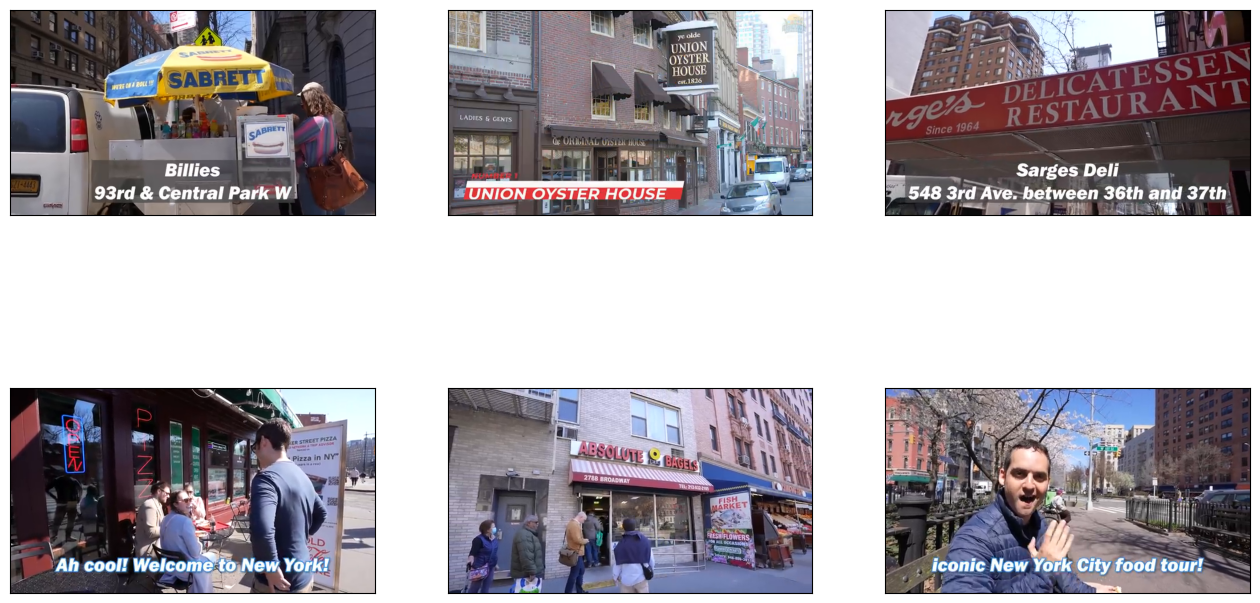

In [105]:
query_str = query_strs[0]

print(f"Query: {query_str}\n")

# list of images, and list of output text
# source_length:length of text output to print.
img, txt = retrieve(retriever_engine=retriever_engine, query_str=query_str, source_length=300)

#image document contains the images we want to process in multi-modal prompt to LLM
image_documents = SimpleDirectoryReader(
    input_dir=output_folder, input_files=img
).load_data()

context_str = "".join(txt)
plot_images(img)

# Send the text and images to llm to answer the question

## input prompt

In [106]:
import json

qa_tmpl_str = (
    "Given the included images and author's transcript retrieved from the video, \n"
    "accurately and precisely answer the query without any additional prior knowledge.\n"
    "Ensure honesty and responsibility, refraining from any racist or sexist remarks.\n"
    "Don't respond with information that is not present in provided information.\n"
    "If you cannot provide information based on the provided images and text, say 'I cannot provide answer based on provided information'.\n"
    "---------------------\n"
    "Query: {query_str}\n"
    "Answer: "
)

In [121]:
import json

qa_tmpl_str = (
    "Given the included images and author's transcript retrieved from the video, \n"
    "accurately and precisely answer the query without any additional prior knowledge.\n"
    "Ensure honesty and responsibility, refraining from any racist or sexist remarks.\n"
    "Don't respond with information that is not present in provided information.\n"
    "---------------------\n"
    "Query: {query_str}\n"
    "Answer: "
)

## multiModal llm model

In [126]:

#specify the MultiModal OpenAI model to use.
openai_mm_llm = OpenAIMultiModal(
    model="gpt-4o"
)


In [127]:
mm_llm = openai_mm_llm

In [128]:
response_1 = mm_llm.complete(
    prompt=qa_tmpl_str.format(
        context_str=context_str, query_str=query_str, metadata_str={}
    ),
    image_documents=image_documents,
)


In [129]:
rich.print(response_1.text)

The best food location in Boston mentioned is the Union Oyster House.

## Notes

we saw 
- how a small difference in the prompt, could change the result
- combining results from multiple videos